In [200]:
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image
import random as rand
import pathlib
from shutil import copyfile
import os
import random
from IPython.display import display
import imageio

In [201]:
DATAPATH = '../data/'

# Create data directories
pathlib.Path(DATAPATH + 'interim/data').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'interim/illumination').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'interim/pose').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'processed/data').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'processed/illumination').mkdir(parents=True, exist_ok=True)
pathlib.Path(DATAPATH + 'processed/pose').mkdir(parents=True, exist_ok=True)

# Load illumination: cropped 40x48 (1920px) images of 68 subjects under 21 different illuminations
illum_dat = sio.loadmat(DATAPATH + '/raw/illumination.mat')
illum_mat = illum_dat['illum']

# Recover image from vector
def recover_img(v, dim1=40, dim2=48, rotate=270):
    rescaled = v.reshape(dim1, dim2).astype(np.uint8)
    return Image.fromarray(rescaled).rotate(rotate, expand=True)

# Save images as person_67_illum_20.png
for illum in range(illum_mat.shape[1]):
    for person in range(illum_mat.shape[2]):
        # Create class folder
        person_no, illum_no = '{0:0=2d}'.format(person), '{0:0=2d}'.format(illum)
        pathlib.Path(DATAPATH + 'interim/illumination/person{0}'.format(person_no)).mkdir(parents=True, exist_ok=True)
        # Create and save image
        img = recover_img(illum_mat[:,illum,person])
        filename = 'person{0}_illum{1}.png'.format(person_no, illum_no)
        img.save(DATAPATH + 'interim/illumination/person{0}/{1}'.format(person_no, filename))

In [202]:
# Check if image is Png
def isPng(filename): return filename.endswith(".png") and '.ipynb_checkpoints' not in filename

# Create test/train split
random.seed(999)
split = 0.8  # 80% of 21 illuminations will be ceilinged to 17, or ~81%
train, test = [], []
subdir = DATAPATH + 'interim/illumination/'
dirs = next(os.walk(subdir))[1]  # class folders

for dir in dirs:
    filenames = os.listdir(subdir + dir)
    img_filenames = [filename for filename in filenames if isPng(filename)]
    img_filepaths = [subdir + dir + os.sep + img_filename for img_filename in img_filenames]
    random.shuffle(img_filepaths) # shuffle class images so train/test have same distribution
    train = train + img_filepaths[:int(split*len(filenames))]
    test = test + img_filepaths[int(split*len(filenames)):]

def name_to_int(s):
    no_alpha = ''.join(i for i in s if not i.isalpha())
    return int(no_alpha)

def parse_filename(s): 
    person, illum = s[:-4].split('_')
    return name_to_int(person), name_to_int(illum)


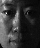

In [203]:
# Preprocess images

def load_image(filepath):
    return imageio.imread(filepath).flatten(order='F')  # column-major flatten

# Mean center
v = load_image(test[0])
recover_img(v)